<a href="https://colab.research.google.com/github/klajosw/python/blob/master/kl_py_COVID19_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"> 
    <img src="https://raw.githubusercontent.com/klajosw/python/master/kl_mie_python_logo_250.jpg" 
         align="left" width="251" height="251">
    
</p>


<p> </p>



# Python COVID19 



## COVID19 fertőzés magyarországi elemzése



<https://klajosw.blogspot.com/>

source: 
<https://github.com/CSSEGISandData/COVID-19>,
<https://github.com/datasets/covid-19>


---


---

# A COVID-19 virus által megerősített magyar esetek elemzése

Ez a minta notebook a COVID-19 által megerősített esetek exponenciális függvény modellezését vizsgálja. 
Noha ez nem teljesen jó modell hosszú vagy akár középtávú előrejelzésekhez, de elég jól képes megjeleníteni a kezdeti kitöréseket, csúcsokat. 

---

In [0]:
## modulok betöltése
import pandas as pd   
import seaborn as sns
sns.set()
# Forrás adatok hoz kapcsolódás (https://github.com/CSSEGISandData/COVID-19, https://github.com/datasets/covid-19, ....)
df = pd.read_csv('https://open-covid-19.github.io/data/data.csv')
df = df.set_index('Date')

---

## A forrás állomány összes ország adatát tartalmmazza, de mi most csak magyarország adatait elemezzük.

## A megerősített és végzetes eseteket tekintjük május 2.-áig. 

*Ha a modellt más országokban vagy dátumokban szeretnénk alkalmazni, csak meg kell változtatni az alábbi kódot.*

---

In [0]:
from datetime import date, timedelta
tegnap = date.today() - timedelta(days=1)  ##  dinamikus tegnapi nap
print(tegnap.strftime('%Y-%m-%d'))

country_code = 'HU'                        ## HU: magyarország
date_limit = '2020-05-02'                  ## közvetlen dátum megadás tegnapi nap (volt)
date_limit = tegnap.strftime('%Y-%m-%d')

2020-05-03


---

## Tekintettel a járványra

Minden hónapra vannak adatokkal, de csak akkortólb érdekel, amikor az esetek száma növekedni kezd. 

A járvány kitörését úgy határozzuk meg, hogy az esetek száma meghaladja a meghatározott küszöböt. 

A mintában én az 5-öt használom.

---

In [0]:
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 5):  
    ''' Vizsgálati maszkot ad vissza> 5 megerősített esethez [járvány kezdete]''' 
    return data['Confirmed'] > threshold


cols = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']  ## mezők kiválasztása
# Ország kiválasztása
country = df[df['CountryCode'] == country_code][cols]
# Vizsgálati vég dátum kiválasztása
country = country[country.index <= date_limit]
# Járvány kezdet országra vonatkoztatás szűrése
country = country[get_outbreak_mask(country)]

---

## Adat vizualizáció


Egy pillantással sok információ kiemelkedik az adat sokaságból, ha diagramosan megjelenítjük.
 
 
---

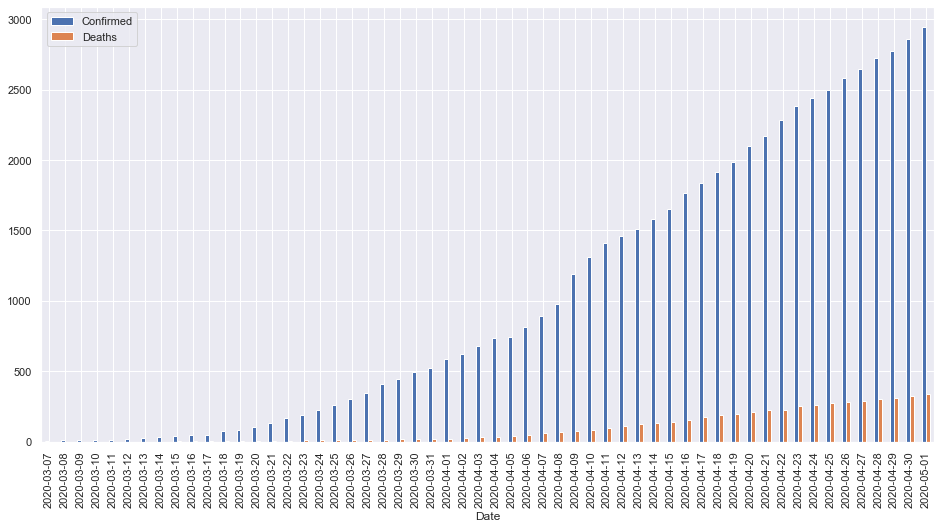

In [0]:
country.plot(kind='bar', figsize=(16, 8));

---

## Adat modelezés


Mivel az adatok kb. egy exponenciális görbét követnek. 

Lássuk, modellezhetjük-e valamilyen paraméter illesztéssel?

---

In [0]:
from scipy import optimize

def exponential_function(x: float, a: float, b: float, c: float):
    ''' a * (b ^ x) + c '''
    return a * (b ** x) + c

X, y = list(range(len(country))), country['Confirmed'].tolist()
params, _ = optimize.curve_fit(exponential_function, X, y)

print('Becslés: {0:.3f} * ({1:.3f} ^ X) + {2:.3f}'.format(*params))

Becslés: 722.406 * (1.032 ^ X) + -905.770


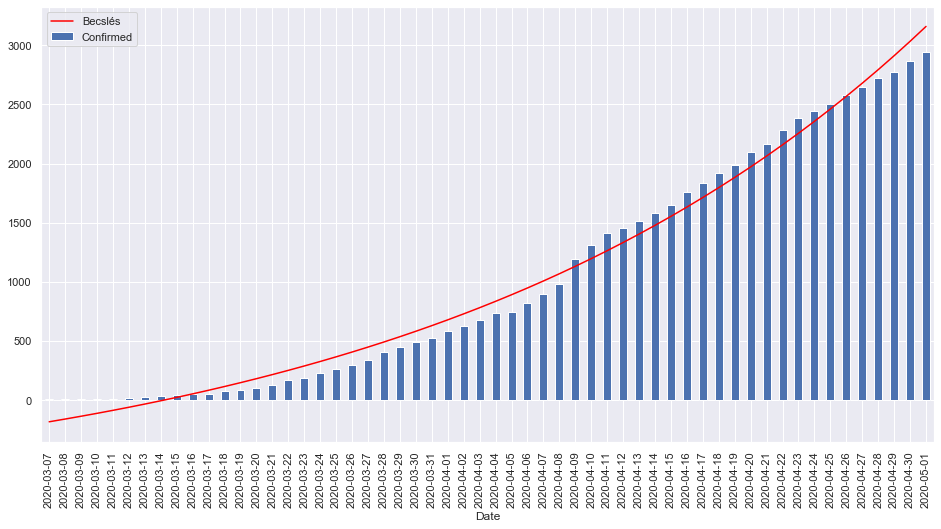

In [0]:
ax = country[['Confirmed']].plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in X]
ax.plot(country.index, estimate, color='red', label='Becslés')
ax.legend();

---

## A modell érvényesítése
Ez a görbe nagyon jól illeszkedik! 

Annak ellenére, hogy a megfelelő epidemiológiai modellek alapvetően különböznek (mivel a betegségek nem növekedhetnek exponenciálisan határozatlan ideig).

Tehát az exponenciális modellnek jónak kell lennie a rövid távú előrejelzésekhez.

Modellünk érvényesítéséhez próbáljuk újra illeszteni, anélkül, hogy átnézzük az utolsó 3 nap adatait. 

Ezután modellünk segítségével becsülhetjük meg a hiányzó napok számát, és összehasonlíthatjuk, hogy a modell mi történt a tényleges adatokkal, hogy az eredmények továbbra is fennállnak-e.

---


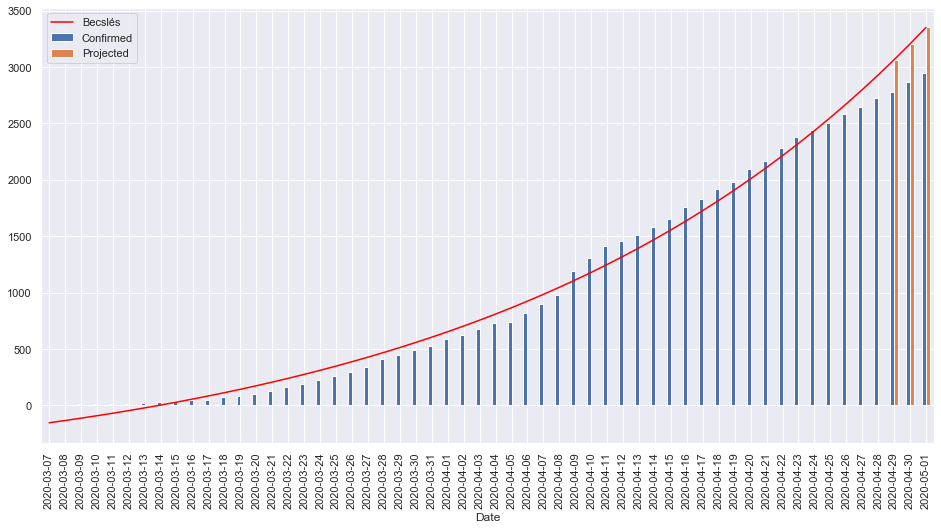

In [0]:
ESTIMATE_DAYS = 3
params_validate, _ = optimize.curve_fit(exponential_function, X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS])

# Projekt nulla az összes értéknél, kivéve az utolsó ESTIMATE_DAYS -nál
projected = [0] * len(X[:-ESTIMATE_DAYS]) + [exponential_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=country.index, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params_validate) for x in X]
ax.plot(country.index, estimate, color='red', label='Becslés')
ax.legend();

---

## A jövőbeli adatok becslés korrekciója

Úgy tűnik, hogy az exponenciális modellünk kissé túlbecsüli a megerősített eseteket. 

Ez jó jel! Ez azt jelenti, hogy a betegség egy kicsit lassul. 

A számok elég közel vannak ahhoz, hogy egy 3 napos előrejelzés valószínűleg elég pontos becslés legyen.

Most használjuk azt a modellt, amelyet korábban illesztettünk, amely az összes adatot felhasználta, és próbáljuk megjósolni, hogy néz ki a következő 3 nap.

---

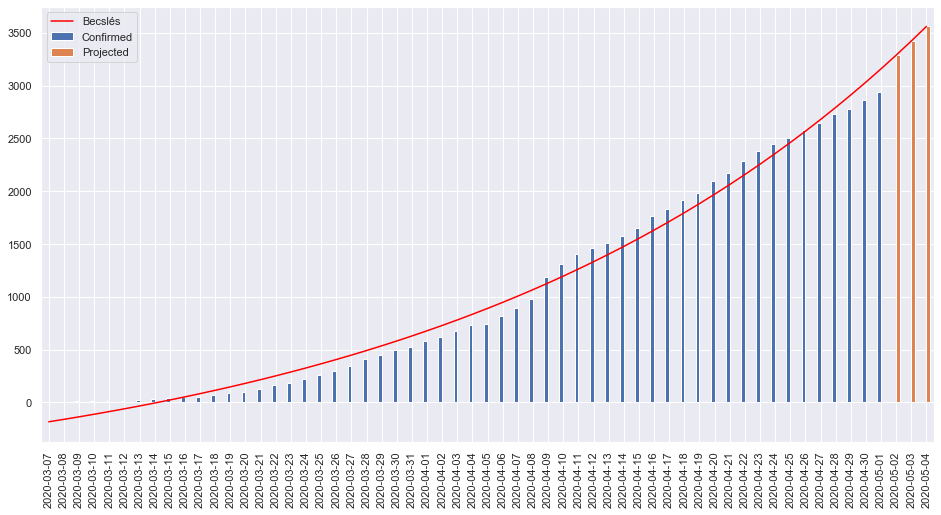

In [0]:
import datetime

FUTURE_DAYS = 3

# Adjon N új napot indexeinkhez
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in country.index]
for _ in range(FUTURE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Végezz vetítést az előzőleg becsült paraméterekkel
projected = [0] * len(X) + [exponential_function(x, *params) for x in range(len(X), len(X) + FUTURE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Becslés')
ax.legend();